In [1]:
import sys
import os
import time
from sklearn import tree,svm
import numpy as np
import joblib
import pydotplus
from IPython.display import Image, display
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd()))+'/data/')
from read_PLAID_data import read_processed_data,read_index,get_feature_name

In [2]:
def incorrect_index(pred,true,data_index):
    if len(pred)!=len(true):
        print('the prediction\'s lenth is not equal to label\'s lenth')
        return None
    inc_index=[]
    for i in range(len(pred)):
        if pred[i]!=true[i]:
            inc_index.append([i,pred[i],true[i],data_index[i,0],data_index[i,1]])
    return inc_index

In [24]:
start_reading_time = time.time()
feature_select=['i_mean','i_wave_factor','i_pp_rms','i_thd','pure_thd','P','P_F','i_hp1','z_hp1','i_hm2','z_hm2','i_hp2','z_hp2','i_hm3','z_hm3','i_hp3','z_hp3','i_hm4','z_hm4','i_hp4','z_hp4','i_hm5','z_hm5','i_hp5','z_hp5','i_hm6','z_hm6','i_hp6','z_hp6','i_hm7','z_hm7','i_hp7','z_hp7']
# feature_select = get_feature_name()
transformer={'electronical':0, 'heater':1, 'machinery':1}
x_module_train, y_module_train, train_index = read_processed_data(
    'module',
    type_header='extra label',
    direaction=1,
    offset=1,
    each_lenth=10,
    feature_select=feature_select,
    Transformer=transformer,
    source='submetered_process2/training')

x_module_validation, y_module_validation, validation_index = read_processed_data(
    'module',
    type_header='extra label',
    direaction=1,
    offset=1,
    each_lenth=10,
    feature_select=feature_select,
    Transformer=transformer,
    source='submetered_process2/validation')

x_module_trainval = np.concatenate((x_module_train, x_module_validation),
                                   axis=0)
y_module_trainval = np.concatenate((y_module_train, y_module_validation),
                                   axis=0)
trainval_index = np.concatenate((train_index, validation_index),
                                   axis=0)

x_module_test, y_module_test, test_index = read_processed_data(
    'module',
    type_header='extra label',
    direaction=1,
    offset=1,
    each_lenth=10,
    feature_select=feature_select,
    Transformer=transformer,
    source='submetered_process2/testing')

x_module_all=np.concatenate((x_module_trainval, x_module_test),
                                   axis=0)
y_module_all=np.concatenate((y_module_trainval, y_module_test),
                                   axis=0)
all_index = np.concatenate((trainval_index, test_index),
                                   axis=0)

print('finished loading data, cost %.3fs'%(time.time()-start_reading_time))   

finished loading data, cost 7.688s


Best score on validation set:0.93127
Best parameters:{'max_depth': 1, 'min_samples_leaf': 100}
Best score on test set:0.95989


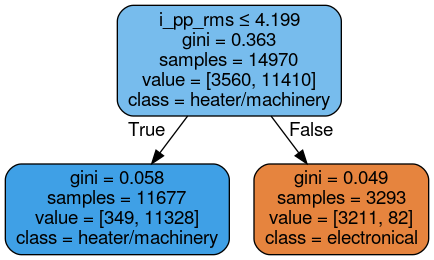

Best score on validation set:0.96645
Best parameters:{'C': 10}
Best score on test set:0.97836


In [19]:
best_score = 0.0
for md in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    for mss in [100, 150, 200, 250, 500, 1000, 1500, 2000]:
        module_tree = tree.DecisionTreeClassifier(max_depth=md,
                                                  min_samples_leaf=mss)
        module_tree.fit(x_module_train, y_module_train)
        score = module_tree.score(x_module_validation, y_module_validation)
        if score > best_score:
            best_score = score
            best_parameters = {'max_depth': md, 'min_samples_leaf': mss}

module_tree = tree.DecisionTreeClassifier(**best_parameters)
module_tree.fit(x_module_trainval, y_module_trainval)
test_score = module_tree.score(x_module_test, y_module_test)
print("Best score on validation set:{:.5f}".format(best_score))
print("Best parameters:{}".format(best_parameters))
print("Best score on test set:{:.5f}".format(test_score))

dot_data = tree.export_graphviz(
    module_tree,
    feature_names=feature_select,
    class_names=['electronical', 'heater/machinery'],
    filled=True,
    rounded=True,
    special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
display(Image(graph.create_png()))

best_score = 0.0
for c in [
        0.001, 0.01, 0.1, 0.51, 2, 5, 10, 15, 25, 50, 100, 150, 200, 300, 350,
        400, 450, 500, 1000, 10000
]:
    module_svm = svm.SVC(C=c)
    module_svm.fit(x_module_train, y_module_train)
    score = module_svm.score(x_module_validation, y_module_validation)
    if score > best_score:
        best_score = score
        best_parameters = {'C': c}

module_svm = svm.SVC(**best_parameters)
module_svm.fit(x_module_trainval, y_module_trainval)
test_score = module_svm.score(x_module_test, y_module_test)
print("Best score on validation set:{:.5f}".format(best_score))
print("Best parameters:{}".format(best_parameters))
print("Best score on test set:{:.5f}".format(test_score))



In [37]:
pred=module_tree.predict(x_module_test)
for i,p in enumerate(pred):
    if p==1:
        if x_module_test[i,5]<10:
            pred[i]=0
inc_index=incorrect_index(pred, y_module_test,test_index)
inc_index.sort(key=lambda x:x[3])
print(1-len(inc_index)/len(y_module_test))

pred=module_tree.predict(x_module_all)
for i,p in enumerate(pred):
    if p==1:
        if x_module_all[i,5]<10:
            pred[i]=0
inc_index=incorrect_index(pred, y_module_all,all_index)
inc_index.sort(key=lambda x:x[3])
print(1-len(inc_index)/len(y_module_all))

0.9815303430079155
0.9662046908315565


In [3]:
start_reading_time = time.time()
feature_select=['i_mean','i_wave_factor','i_pp_rms','i_thd','pure_thd','P','P_F','i_hp1','z_hp1','i_hm2','z_hm2','i_hp2','z_hp2','i_hm3','z_hm3','i_hp3','z_hp3','i_hm4','z_hm4','i_hp4','z_hp4','i_hm5','z_hm5','i_hp5','z_hp5','i_hm6','z_hm6','i_hp6','z_hp6','i_hm7','z_hm7','i_hp7','z_hp7']
# feature_select = get_feature_name()
transformer={'heater':0, 'machinery':1}
x_module_train, y_module_train, train_index = read_processed_data(
    'module',
    type_header='extra label',
    selected_label=['machinery','heater'],
    direaction=1,
    offset=1,
    each_lenth=10,
    feature_select=feature_select,
    Transformer=transformer,
    source='submetered_process2/training')

x_module_validation, y_module_validation, validation_index = read_processed_data(
    'module',
    type_header='extra label',
    selected_label=['machinery','heater'],
    direaction=1,
    offset=1,
    each_lenth=10,
    feature_select=feature_select,
    Transformer=transformer,
    source='submetered_process2/validation')

x_module_trainval = np.concatenate((x_module_train, x_module_validation),
                                   axis=0)
y_module_trainval = np.concatenate((y_module_train, y_module_validation),
                                   axis=0)
trainval_index = np.concatenate((train_index, validation_index),
                                   axis=0)

x_module_test, y_module_test, test_index = read_processed_data(
    'module',
    type_header='extra label',
    selected_label=['machinery','heater'],
    direaction=1,
    offset=1,
    each_lenth=10,
    feature_select=feature_select,
    Transformer=transformer,
    source='submetered_process2/testing')

x_module_all=np.concatenate((x_module_trainval, x_module_test),
                                   axis=0)
y_module_all=np.concatenate((y_module_trainval, y_module_test),
                                   axis=0)
all_index = np.concatenate((trainval_index, test_index),
                                   axis=0)

print('finished loading data, cost %.3fs'%(time.time()-start_reading_time))   

finished loading data, cost 8.767s


Best score on validation set:0.87234
Best parameters:{'max_depth': 5, 'min_samples_leaf': 100}
Best score on test set:0.74394


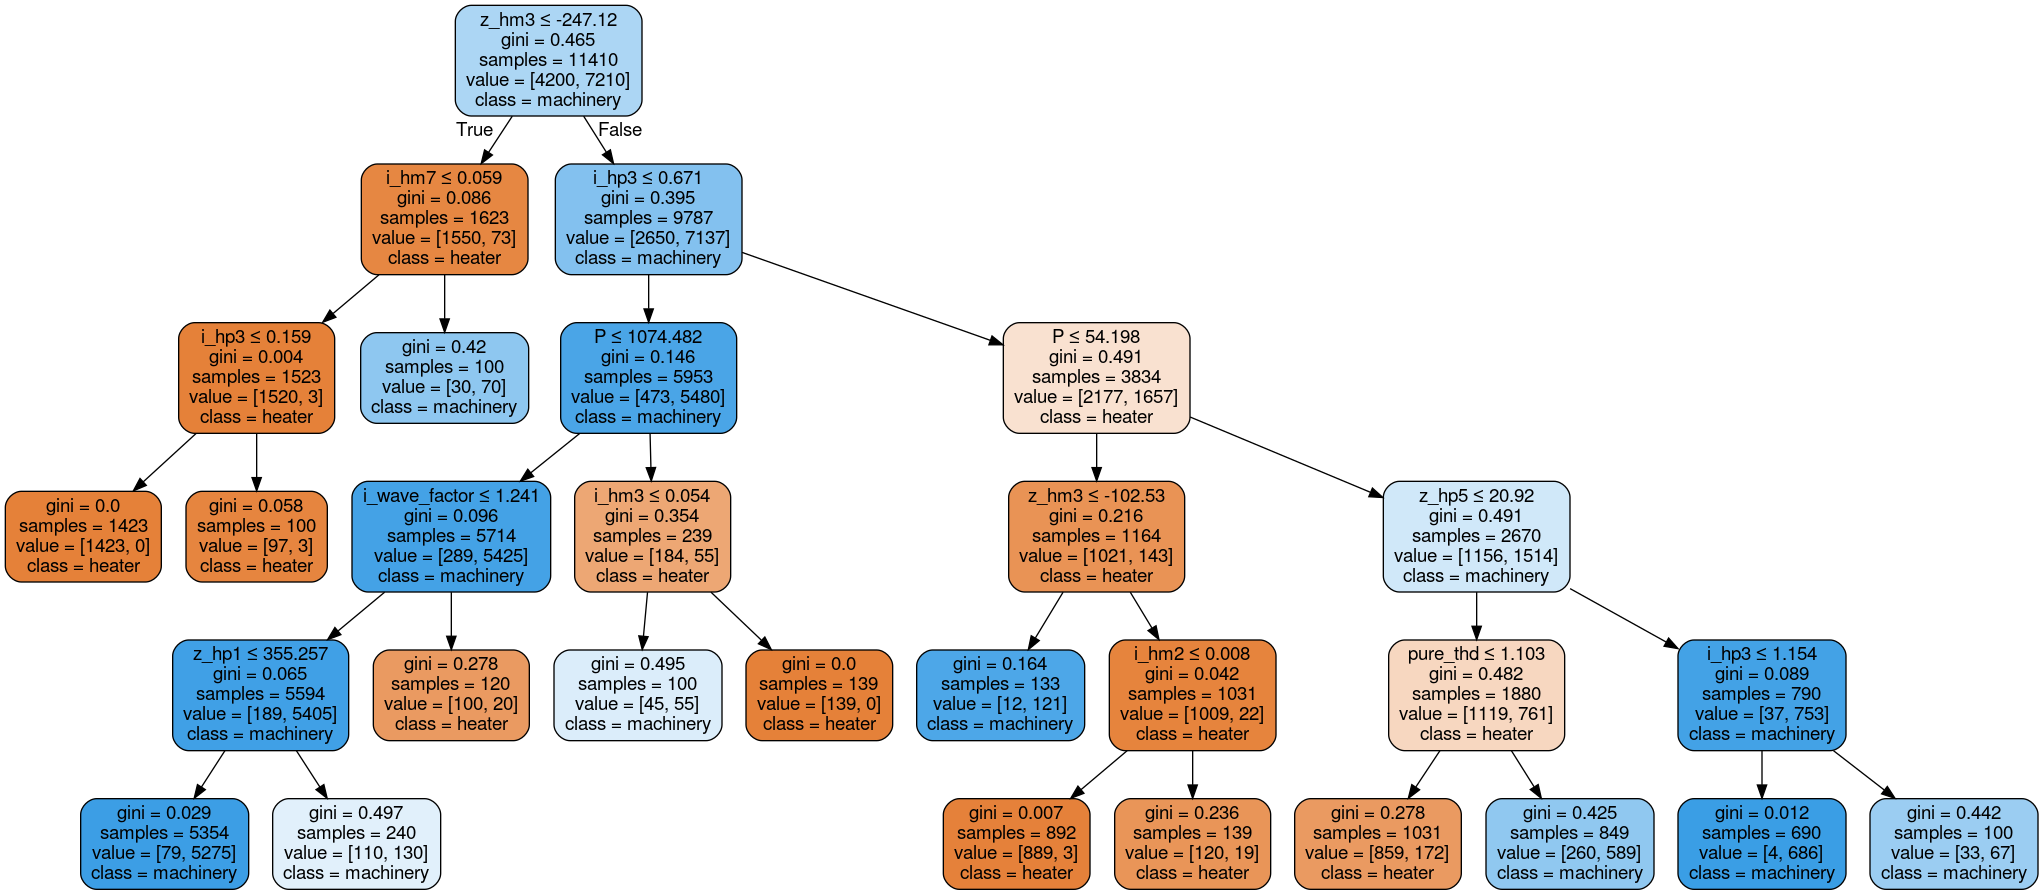

Best score on validation set:0.79660
Best parameters:{'C': 1000}
Best score on test set:0.83114


In [40]:
best_score = 0.0
for md in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    for mss in [100, 150, 200, 250, 500, 1000, 1500, 2000]:
        module_tree = tree.DecisionTreeClassifier(max_depth=md,
                                                  min_samples_leaf=mss)
        module_tree.fit(x_module_train, y_module_train)
        score = module_tree.score(x_module_validation, y_module_validation)
        if score > best_score:
            best_score = score
            best_parameters = {'max_depth': md, 'min_samples_leaf': mss}

module_tree = tree.DecisionTreeClassifier(**best_parameters)
module_tree.fit(x_module_trainval, y_module_trainval)
test_score = module_tree.score(x_module_test, y_module_test)
print("Best score on validation set:{:.5f}".format(best_score))
print("Best parameters:{}".format(best_parameters))
print("Best score on test set:{:.5f}".format(test_score))

feature_name = get_feature_name()
del feature_name[0]

dot_data = tree.export_graphviz(
    module_tree,
    feature_names=feature_select,
    class_names=['heater', 'machinery'],
    filled=True,
    rounded=True,
    special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
display(Image(graph.create_png()))

best_score = 0.0
for c in [
        0.001, 0.01, 0.1, 0.51, 2, 5, 10, 15, 25, 50, 100, 150, 200, 300, 350,
        400, 450, 500, 1000, 10000
]:
    module_svm = svm.SVC(C=c)
    module_svm.fit(x_module_train, y_module_train)
    score = module_svm.score(x_module_validation, y_module_validation)
    if score > best_score:
        best_score = score
        best_parameters = {'C': c}

module_svm = svm.SVC(**best_parameters)
module_svm.fit(x_module_trainval, y_module_trainval)
test_score = module_svm.score(x_module_test, y_module_test)
print("Best score on validation set:{:.5f}".format(best_score))
print("Best parameters:{}".format(best_parameters))
print("Best score on test set:{:.5f}".format(test_score))

In [2]:
start_reading_time = time.time()
feature_select=['i_mean','i_wave_factor','i_pp_rms','i_thd','pure_thd','P','Q','P_F','i_hm1','z_hm1','i_hp1','z_hp1','i_hm2','z_hm2','i_hp2','z_hp2','i_hm3','z_hm3','i_hp3','z_hp3','i_hm4','z_hm4','i_hp4','z_hp4','i_hm5','z_hm5','i_hp5','z_hp5','i_hm6','z_hm6','i_hp6','z_hp6','i_hm7','z_hm7','i_hp7','z_hp7']
# feature_select = get_feature_name()
transformer={'heater':0, 'machinery':1}
x_heat, y_heat, heat_index = read_processed_data(
    'module',
    type_header='extra label',
    selected_label=['heater'],
    direaction=1,
    offset=1,
    each_lenth=1,
    feature_select=feature_select,
    Transformer=transformer,
    source='submetered_process2/training')

x_machinery, y_machinery, machinery_index = read_processed_data(
    'module',
    type_header='extra label',
    selected_label=['machinery'],
    direaction=1,
    offset=1,
    each_lenth=1,
    feature_select=feature_select,
    Transformer=transformer,
    source='submetered_process2/training')


print('finished loading data, cost %.3fs'%(time.time()-start_reading_time)) 

finished loading data, cost 10.341s


In [15]:
start_reading_time = time.time()
# feature_select=['i_mean','i_wave_factor','i_pp_rms','i_thd','pure_thd','P','Q','P_F','i_hm1','z_hm1','i_hp1','z_hp1','i_hm2','z_hm2','i_hp2','z_hp2','i_hm3','z_hm3','i_hp3','z_hp3','i_hm4','z_hm4','i_hp4','z_hp4','i_hm5','z_hm5','i_hp5','z_hp5','i_hm6','z_hm6','i_hp6','z_hp6','i_hm7','z_hm7','i_hp7','z_hp7']
# feature_select = get_feature_name()
feature_select=['P_F']
x_P_F, y_P_F, P_F_index = read_processed_data(
    'module',
    type_header='extra label',
    selected_label=['machinery','heater'],
    direaction=1,
    offset=1,
    each_lenth=1,
    feature_select=feature_select,
    source='submetered_process2/training')


In [17]:
def getKey(dic,value):
    for key in dic:
        if value in dic[key]:
            return key
    return None


type_index=read_index('type')
Heater_index=[]
Heater=[]
Machinery_index=[]
Machinery=[]
P_F_split=0.98
for i,pf in enumerate(x_P_F):
    if x_P_F[i]>=0.963:
        Heater_index.append(P_F_index[i,0])
        Heater.append(getKey(type_index,P_F_index[i,0]))
    else:
        Machinery_index.append(P_F_index[i,0])
        Machinery.append(getKey(type_index,P_F_index[i,0]))



    

In [4]:
#用2.1数据进行发热和电机相关设备进行划分，检查是否可能标签标错了
feature_select = get_feature_name()
selected_label = [
    'Air Conditioner', 'Blender', 'Coffee maker', 'Fan', 'Fridge', 'Hair Iron',
    'Hairdryer', 'Heater', 'Incandescent Light Bulb', 'Microwave',
    'Soldering Iron', 'Vacuum', 'Washing Machine', 'Water kettle'
]
x_mh_train, y_mh_train, mh_index_train = read_processed_data(
    'type',
    type_header='appliance',
    selected_label=selected_label,
    direaction=1,
    offset=1,
    each_lenth=1,
    feature_select=feature_select,
    source='submetered_process2.1/training')
 
x_mh_validation, y_mh_validation, mh_index_validation = read_processed_data(
    'type',
    type_header='appliance',
    selected_label=selected_label,
    direaction=1,
    offset=1,
    each_lenth=1,
    feature_select=feature_select,
    source='submetered_process2.1/validation')

x_mh_trainval = np.concatenate((x_mh_train, x_mh_validation),
                                   axis=0)
y_mh_trainval = np.concatenate((y_mh_train, y_mh_validation),
                                   axis=0)

x_mh_test, y_mh_test, mh_index_test = read_processed_data(
    'type',
    type_header='appliance',
    selected_label=selected_label,
    direaction=1,
    offset=1,
    each_lenth=1,
    feature_select=feature_select,
    source='submetered_process2.1/testing')   


Best score on validation set:0.67317
Best parameters:{'max_depth': 3, 'min_samples_leaf': 1}
Best score on test set:0.58661


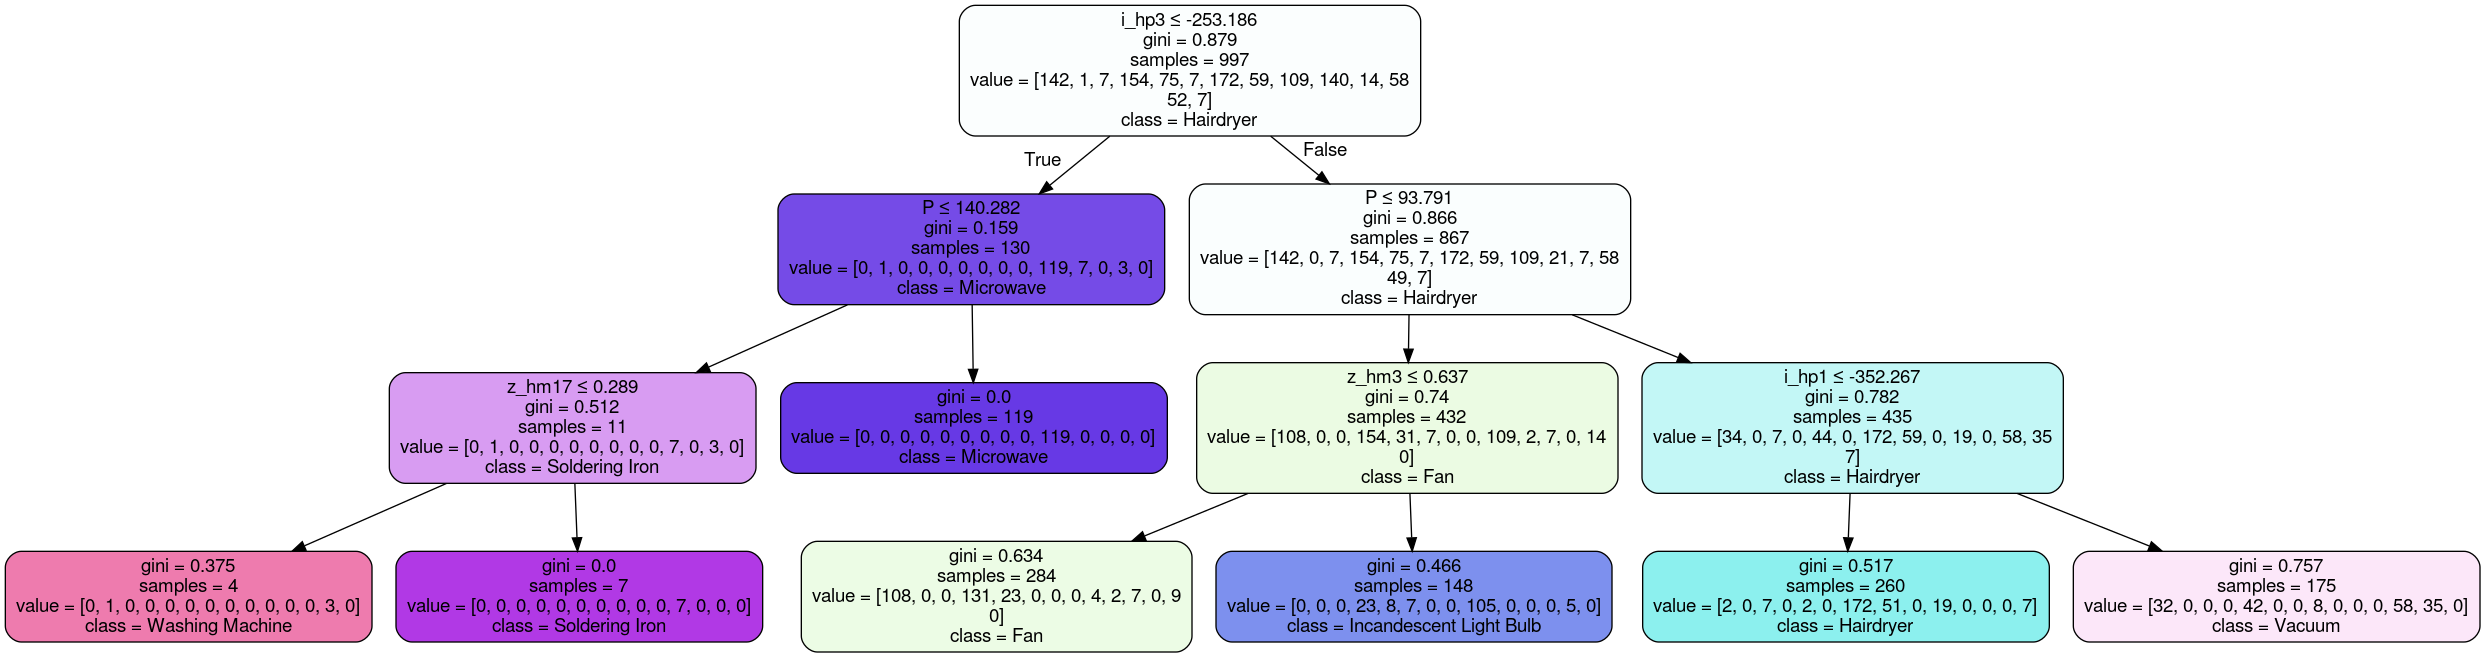

In [7]:
#用2.1数据进行发热和电机相关设备进行划分，检查是否可能标签标错了
best_score = 0.0
for md in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    for mss in [1, 2, 5, 10, 15, 20, 25, 50]:
        mh_tree = tree.DecisionTreeClassifier(max_depth=md,
                                                  min_samples_leaf=mss)
        mh_tree.fit(x_mh_train, y_mh_train)
        score = mh_tree.score(x_mh_validation, y_mh_validation)
        if score > best_score:
            best_score = score
            best_parameters = {'max_depth': 3, 'min_samples_leaf': 1}

mh_tree = tree.DecisionTreeClassifier(**best_parameters)
mh_tree.fit(x_mh_trainval, y_mh_trainval)
test_score = mh_tree.score(x_mh_test, y_mh_test)
print("Best score on validation set:{:.5f}".format(best_score))
print("Best parameters:{}".format(best_parameters))
print("Best score on test set:{:.5f}".format(test_score))

dot_data = tree.export_graphviz(
    mh_tree,
    feature_names=feature_select,
    class_names=selected_label,
    filled=True,
    rounded=True,
    special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
display(Image(graph.create_png()))


In [10]:
# 换2.1数据集再试一试两个大类的区分
start_reading_time = time.time()
feature_select=['i_mean','i_wave_factor','i_pp_rms','i_thd','pure_thd','P','P_F','i_hp1','z_hp1','i_hm2','z_hm2','i_hp2','z_hp2','i_hm3','z_hm3','i_hp3','z_hp3','i_hm4','z_hm4','i_hp4','z_hp4','i_hm5','z_hm5','i_hp5','z_hp5','i_hm6','z_hm6','i_hp6','z_hp6','i_hm7','z_hm7','i_hp7','z_hp7']
# feature_select = get_feature_name()
transformer={'heater':0, 'machinery':1}
x_module_train, y_module_train, train_index = read_processed_data(
    'module',
    type_header='extra label',
    selected_label=['machinery','heater'],
    direaction=1,
    offset=1,
    each_lenth=10,
    feature_select=feature_select,
    Transformer=transformer,
    source='submetered_process2.1/training')

x_module_validation, y_module_validation, validation_index = read_processed_data(
    'module',
    type_header='extra label',
    selected_label=['machinery','heater'],
    direaction=1,
    offset=1,
    each_lenth=10,
    feature_select=feature_select,
    Transformer=transformer,
    source='submetered_process2.1/validation')

x_module_trainval = np.concatenate((x_module_train, x_module_validation),
                                   axis=0)
y_module_trainval = np.concatenate((y_module_train, y_module_validation),
                                   axis=0)
trainval_index = np.concatenate((train_index, validation_index),
                                   axis=0)

x_module_test, y_module_test, test_index = read_processed_data(
    'module',
    type_header='extra label',
    selected_label=['machinery','heater'],
    direaction=1,
    offset=1,
    each_lenth=10,
    feature_select=feature_select,
    Transformer=transformer,
    source='submetered_process2.1/testing')

x_module_all=np.concatenate((x_module_trainval, x_module_test),
                                   axis=0)
y_module_all=np.concatenate((y_module_trainval, y_module_test),
                                   axis=0)
all_index = np.concatenate((trainval_index, test_index),
                                   axis=0)

print('finished loading data, cost %.3fs'%(time.time()-start_reading_time)) 

finished loading data, cost 6.618s


Best score on validation set:0.85415
Best parameters:{'max_depth': 2, 'min_samples_leaf': 1500}
Best score on test set:0.82079


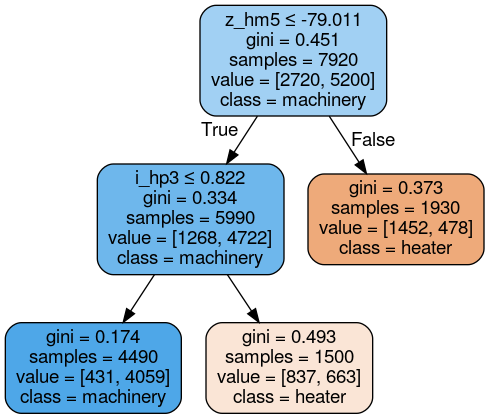

Best score on validation set:0.86000
Best parameters:{'C': 10000}
Best score on test set:0.75289


In [12]:
best_score = 0.0
for md in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    for mss in [100, 150, 200, 250, 500, 1000, 1500, 2000]:
        module_tree = tree.DecisionTreeClassifier(max_depth=md,
                                                  min_samples_leaf=mss)
        module_tree.fit(x_module_train, y_module_train)
        score = module_tree.score(x_module_validation, y_module_validation)
        if score > best_score:
            best_score = score
            best_parameters = {'max_depth': md, 'min_samples_leaf': mss}

module_tree = tree.DecisionTreeClassifier(**best_parameters)
module_tree.fit(x_module_train, y_module_train)
test_score = module_tree.score(x_module_test, y_module_test)
print("Best score on validation set:{:.5f}".format(best_score))
print("Best parameters:{}".format(best_parameters))
print("Best score on test set:{:.5f}".format(test_score))

feature_name = get_feature_name()
del feature_name[0]

dot_data = tree.export_graphviz(
    module_tree,
    feature_names=feature_select,
    class_names=['heater', 'machinery'],
    filled=True,
    rounded=True,
    special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
display(Image(graph.create_png()))

best_score = 0.0
for c in [
        0.001, 0.01, 0.1, 0.51, 2, 5, 10, 15, 25, 50, 100, 150, 200, 300, 350,
        400, 450, 500, 1000, 10000
]:
    module_svm = svm.SVC(C=c)
    module_svm.fit(x_module_train, y_module_train)
    score = module_svm.score(x_module_validation, y_module_validation)
    if score > best_score:
        best_score = score
        best_parameters = {'C': c}

module_svm = svm.SVC(**best_parameters)
module_svm.fit(x_module_train, y_module_train)
test_score = module_svm.score(x_module_test, y_module_test)
print("Best score on validation set:{:.5f}".format(best_score))
print("Best parameters:{}".format(best_parameters))
print("Best score on test set:{:.5f}".format(test_score))